## My solutions to Easy21, a Reinforcement Learning Assignment by David Silver
[Link to assignment](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/Easy21-Johannes.pdf)  
[UCL Advanced Topics in Machine Learning Course](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html)  
[Sutton and Barto RL Book](http://incompleteideas.net/book/RLbook2018.pdf)

##### • What are the pros and cons of bootstrapping in Easy21?  
Bootstrapping is the idea of updating an estimate based on an estimate. It can make learning faster by reducing variance, since learning can take place immediately, rather than only at the end of the episode. Another benefit is being less memory intensive since sequences of steps are kept only temporarily (based on lambda). In Easy21, bootstrapping works effectively since the state-action value functions changes quickly and significantly, over small step sizes. The issues with bootstrapping are introducing bias, from the initial guesses of the value function, and being part of the _deadly triad_ (together with function approximation and off-policy training), which can lead to instability and divergence. The only con in using bootstrapping in Easy21 is if the value function is initialized with very different values than the optimal value function.  
##### • Would you expect bootstrapping to help more in blackjack or Easy21? Why?  
Since Easy21 is a game with longer time steps (since cards are sometimes subtracted from the player sum), it should benefit more from bootstrapping than blackjack.
##### • What are the pros and cons of function approximation in Easy21?  
Function approximation reduces the computational costs of finding the optimal value function, especially since by using on-policy learning, convergence is much faster. An additional benefit is generalizing learning over many action-value states at once. The cons are an imperfect generalization, nonstationarity, delayed targets, and together with bootstrapping, unstable learning and divergence. Since Easy21 is a game with a stationary optimal value function, when on-policy learning is used, some of the downsides are avoided.
##### • How would you modify the function approximator suggested in this section to get better results in Easy21?  
Use a nonlinear function approximator, such as a neural network, to learn features automatically. Overlapping features introduce issues without discretization, and therefore another viable possibility is using tile coding with overlapping tilings to get a high resolution of the action-value space while still using lower memory than a full grid representation.

In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [20]:
def sample_card(player_sum):
    card = np.random.randint(1, 11)
    color = np.random.randint(1, 4)
    if color == 3:
        return player_sum - card
    else:
        return player_sum + card
    
def bust(player_sum):
    return player_sum > 21 or player_sum < 1

def step(state, action):
    dealer_card, player_sum = state
    if action == 0:
        player_sum = sample_card(player_sum)
        if bust(player_sum):
            return ((dealer_card, player_sum), -1, True)
        return ((dealer_card, player_sum), 0, False)
    elif action == 1:
        dealer_sum = dealer_card
        while dealer_sum < 17:
            dealer_sum = sample_card(dealer_sum)
            if bust(dealer_sum):
                return ((dealer_card, player_sum), 1, True)
        if dealer_sum < player_sum:
            return ((dealer_card, player_sum), 1, True)
        elif dealer_sum == player_sum:
            return ((dealer_card, player_sum), 0, True)
        else:
            return ((dealer_card, player_sum), -1, True)

In [21]:
def r_argmax(q_values):
    top = float("-inf")
    ties = []
    for i in range(len(q_values)):
        if q_values[i] > top:
            top, ties = q_values[i], [i]
        elif q_values[i] == top:
            ties.append(i)
    return np.random.choice(ties)

In [22]:
class MonteCarloAgent:
    def __init__(self):
        self.q_values = np.zeros((11, 22, 2))
        self.epsilon = 0
        self.alpha_t = 0
        self.action_visits = np.zeros((11, 22, 2))
        self.default_visits = 100
        self.state_action_history = None
    
    def start(self, state):
        action = np.random.randint(2)
        self.action_visits[state[0], state[1], action] += 1
        self.state_action_history = []
        self.state_action_history.append((state, action))
        self.last_state = state
        self.last_action = action
        return action
    
    def step(self, state):
        self.epsilon = self.default_visits / (self.default_visits + \
                np.sum(self.action_visits[self.last_state[0],\
                                          self.last_state[1]]))
        if np.random.random() < self.epsilon:
            action = np.random.randint(2)
        else:
            action = r_argmax(self.q_values[state[0], state[1]])
        self.last_state = state
        self.state_action_history.append((state, action))
        return action
    
    def end(self, reward):
        self.last_state, self.last_action = self.state_action_history.pop(0)
        for state, action in self.state_action_history:
            last_state_action = (self.last_state[0],\
                                 self.last_state[1],\
                                 self.last_action)
            self.alpha_t = 1 / self.action_visits[last_state_action]
            self.q_values[last_state_action] += self.alpha_t * \
                    (reward - self.q_values[last_state_action])
            
            self.action_visits[state[0], state[1], action] += 1
            self.last_state = state
            self.last_action = action
            
        last_state_action = (self.last_state[0],\
                             self.last_state[1],\
                             self.last_action)
        self.alpha_t = 1 / self.action_visits[last_state_action]
        self.q_values[last_state_action] += self.alpha_t * \
                (reward - self.q_values[last_state_action])

In [23]:
monteCarloAgent = MonteCarloAgent()
for episode in range(100000):
    state = (np.random.randint(1, 11), np.random.randint(1, 11))
    action = monteCarloAgent.start(state)
    terminal = False
    while True:
        state, reward, terminal = step(state, action)
        if not terminal:
            action = monteCarloAgent.step(state)
        else:
            monteCarloAgent.end(reward)
            break

In [24]:
optimal_values = np.amax(monteCarloAgent.q_values, axis=2)

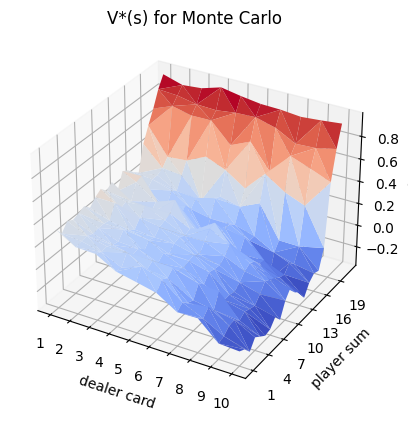

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = []
y = []
for i in range(1, 11):
    for j in range(1, 22):
        x.append(i)
        y.append(j)
z = optimal_values[1:, 1:].flatten()
ax.set_xlabel('dealer card')
ax.set_ylabel('player sum')
ax.set_zlabel('value')
ax.set_title('V*(s) for Monte Carlo')
surface = ax.plot_trisurf(x, y, z, cmap=cm.coolwarm)
plt.xticks(np.arange(1, 11))
plt.yticks(np.arange(1, 22, 3))
plt.show()

In [26]:
class SarsaLambdaAgent:
    def __init__(self, lambdaa):
        self.q_values = np.zeros((11, 22, 2))
        self.epsilon = 0
        self.alpha_t = 0
        self.lambdaa = lambdaa
        self.value_visits = np.zeros((11, 22))
        self.action_visits = np.zeros((11, 22, 2))
        self.eligibility_traces = np.zeros((11, 22, 2))
        self.default_visits = 100
            
    def start(self, state):
        action = np.random.randint(2)
        self.action_visits[state[0], state[1], action] += 1
        self.eligibility_traces = np.zeros((11, 22, 2))
        self.eligibility_traces[state[0], state[1], action] += 1
        self.value_visits[state[0], state[1]] += 1
        self.last_state = state
        self.last_action = action
        return action
    
    def step(self, state, reward):
        last_state_action = (self.last_state[0],\
                             self.last_state[1],\
                             self.last_action)
        self.alpha_t = 1 / self.action_visits[last_state_action]
        self.epsilon = self.default_visits / (self.default_visits \
                + self.value_visits[self.last_state[0], self.last_state[1]])
        
        if np.random.random() < self.epsilon:
            action = np.random.randint(2)
        else:
            action = r_argmax(self.q_values[state[0], state[1], :])
        state_action = (state[0], state[1], action)
            
        delta = reward + self.q_values[state_action] \
                - self.q_values[last_state_action]
        
        self.q_values += self.alpha_t * delta * self.eligibility_traces
        self.eligibility_traces *= self.lambdaa
        
        self.eligibility_traces[state_action] += 1
        self.action_visits[state_action] += 1
        self.value_visits[state[0], state[1]] += 1
        
        self.last_state = state
        self.last_action = action
        return action
    
    def end(self, reward):
        last_state_action = (self.last_state[0],\
                             self.last_state[1],\
                             self.last_action)
        self.alpha_t = 1 / self.action_visits[last_state_action]    
        delta = reward - self.q_values[last_state_action]
        self.q_values += self.alpha_t * delta * self.eligibility_traces
    
    def get_q_values(self):
        return self.q_values

In [27]:
lambdaas = list(np.arange(0, 11, 1.0) / 10)
def run_td_lambda(ExperimentAgentClass, num_episodes, show=[True] * 11,\
                  plot_all_lambdas=False):
    mses = []
    running_mses = [[] for _ in range(11)]
    for lambdaa in lambdaas:
        agent = ExperimentAgentClass(lambdaa)
        for episode in range(num_episodes):
            state = (np.random.randint(1, 11), np.random.randint(1, 11))
            action = agent.start(state)
            terminal = False
            while True:
                state, reward, terminal = step(state, action)
                if not terminal:
                    action = agent.step(state, reward)
                else:
                    agent.end(reward)
                    break
            current_mse = np.mean((monteCarloAgent.q_values \
                                   - agent.get_q_values()) ** 2) 
            running_mses[int(lambdaa * 10)].append(current_mse)
            
        final_mse = np.mean((monteCarloAgent.q_values \
                             - agent.get_q_values()) ** 2)
        mses.append(final_mse)
        
        if show[int(lambdaa * 10)]:
            optimal_values = np.amax(agent.get_q_values(), axis=2)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            x = []
            y = []
            for i in range(1, 11):
                for j in range(1, 22):
                    x.append(i)
                    y.append(j)
            z = optimal_values[1:, 1:].flatten()
            ax.set_xlabel('dealer card')
            ax.set_ylabel('player sum')
            ax.set_zlabel('value')
            ax.set_title('V*(s) for {}({})\nMSE {:0.3f} ({} episodes)' \
                    .format(ExperimentAgentClass.__name__, lambdaa,\
                    final_mse, num_episodes))
            surface = ax.plot_trisurf(x, y, z, cmap=cm.coolwarm)
            plt.xticks(np.arange(1, 11))
            plt.yticks(np.arange(1, 22, 3))
            plt.show()
    
    for lambdaa in lambdaas:
        if show[int(lambdaa * 10)] or plot_all_lambdas:
            plt.plot(list(range(num_episodes)), running_mses[int(lambdaa * 10)])
    showing_lambdaas = (np.array(show) | np.array([plot_all_lambdas] * 11))
    num_columns = int(np.ceil(np.sum(showing_lambdaas) / 3))
    plt.legend(['λ={}'.format(lambdaa) for lambdaa in lambdaas ],\
               loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title('Learning curve of {}'.format(ExperimentAgentClass.__name__))
    plt.xlabel('episode number')
    plt.ylabel('mean square error')
    plt.grid(True)
    plt.show()
        
    plt.plot(lambdaas, mses)
    plt.xlabel('lambda factor')
    plt.ylabel('mean square error')
    plt.title('MSE of {} V* after {} episodes'\
            .format(ExperimentAgentClass.__name__, num_episodes))
    plt.grid(True)
    plt.show()

In [28]:
run_td_lambda(SarsaLambdaAgent, 1000, show=[True, *[False] * 9, True ])

TypeError: gca() got an unexpected keyword argument 'projection'

<Figure size 640x480 with 0 Axes>

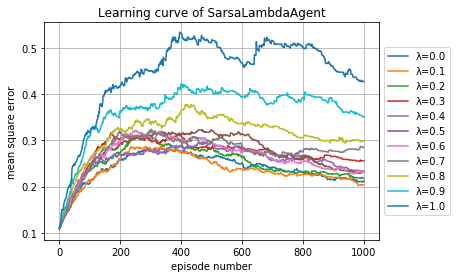

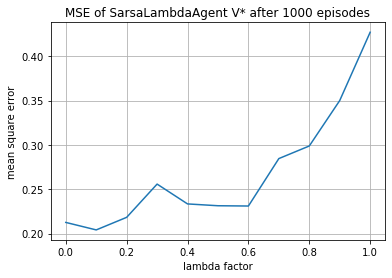

In [22]:
run_td_lambda(SarsaLambdaAgent, 1000, show=[*[False] * 11], plot_all_lambdas=True)

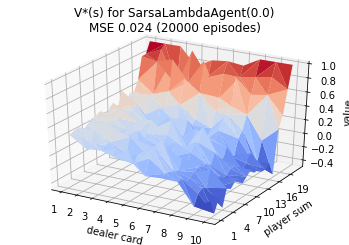

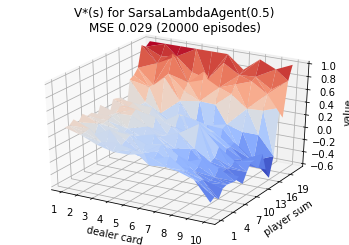

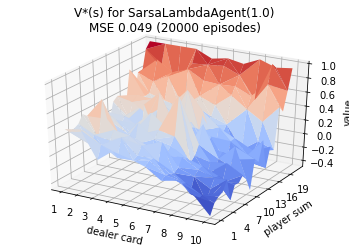

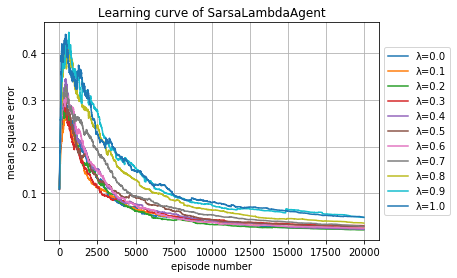

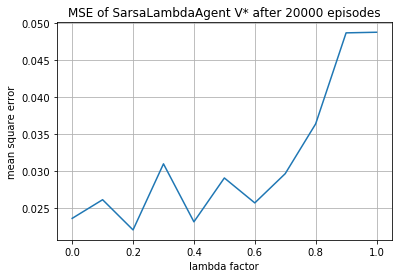

In [23]:
run_td_lambda(SarsaLambdaAgent, 20000, show=[True, *[*[False] * 4, True] * 2], plot_all_lambdas=True)

In [24]:
class LinearFunctionApproximationAgent:
    def __init__(self, lambdaa):
        self.epsilon = 0.05
        self.alpha_t = 0.01
        self.lambdaa = lambdaa
        self.eligibility_traces = np.zeros((3, 6, 2))
        self.weights = (np.random.rand(3, 6, 2) - 0.5) * 0.001
        self.intervals = np.array([[(1, 4), (4, 7), (7, 10)],
                [(1, 6), (4, 9), (7, 12), (10, 15), (13, 18), (16, 21)],
                [(0, 0), (1, 1)]])
    
    def __phi(self, state_action):
        return np.array([dealer_low <= state_action[0] <= dealer_high and \
                             player_low <= state_action[1] <= player_high and \
                             action_low <= state_action[2] <= action_high \
                             for dealer_low, dealer_high in self.intervals[0] \
                             for player_low, player_high in self.intervals[1] \
                             for action_low, action_high in self.intervals[2] \
                            ]).astype(int).reshape(3, 6, 2)
                   
    def start(self, state):
        action = np.random.randint(2)
        self.eligibility_traces = np.zeros((3, 6, 2))
        self.eligibility_traces += self.__phi((state[0], state[1], action))
        self.last_state = state
        self.last_action = action
        return action
    
    def step(self, state, reward):
        if np.random.random() < self.epsilon:
            action = np.random.randint(2)
        else:
            action = r_argmax([np.sum(\
                    self.__phi((state[0], state[1], a)) * self.weights)\
                                              for a in [0, 1]])
        last_state_action = (self.last_state[0],\
                             self.last_state[1],\
                             self.last_action)
        state_action = (state[0], state[1], action)
        
        current_value = np.sum(self.__phi((state_action)) * self.weights)
        last_value = np.sum(self.__phi(last_state_action) * self.weights)
        delta = reward + current_value - last_value
        self.weights += self.alpha_t * delta * self.eligibility_traces
        
        self.eligibility_traces *= self.lambdaa
        self.eligibility_traces += self.__phi((state_action))
        
        self.last_state = state
        self.last_action = action
        return action
    
    def end(self, reward):
        last_state_action = (self.last_state[0],\
                             self.last_state[1],\
                             self.last_action)
        last_value = np.sum(self.__phi((last_state_action)) * self.weights)
        delta = reward - last_value
        self.weights += self.alpha_t * delta * self.eligibility_traces
        
    def get_q_values(self):
        q_values = np.zeros((11, 22, 2))
        for dealer in range(11):
            for player_sum in range(22):
                for action in range(2):
                    q_values[dealer, player_sum, action] = np.sum(\
                            self.__phi((dealer, player_sum, action))\
                                    * self.weights)
        return q_values

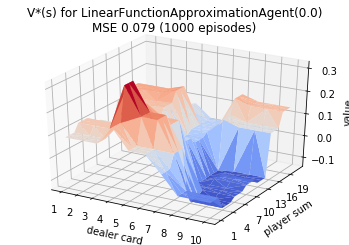

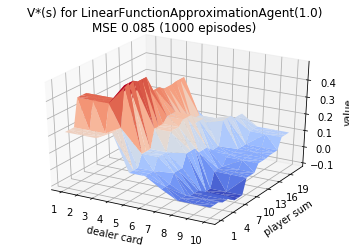

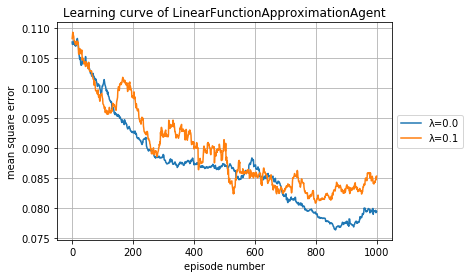

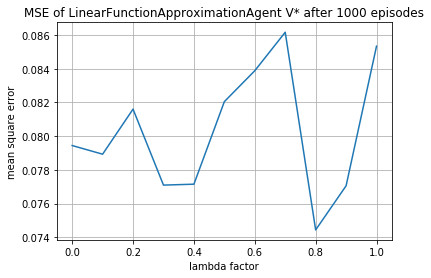

In [25]:
run_td_lambda(LinearFunctionApproximationAgent, 1000, show=[True, *[False] * 9, True])

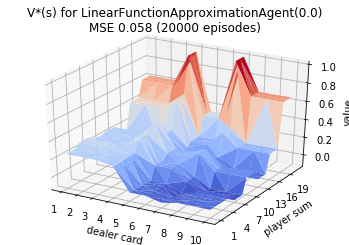

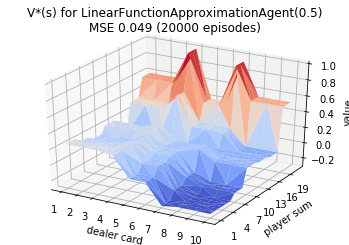

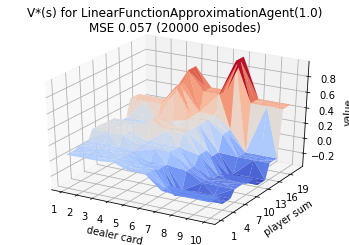

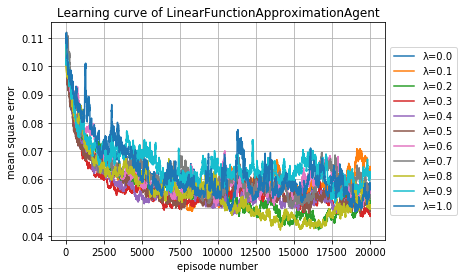

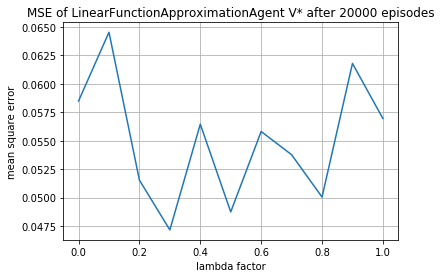

In [26]:
run_td_lambda(LinearFunctionApproximationAgent, 20000, show=[True, *[*[False] * 4, True] * 2], plot_all_lambdas=True)